# TFM - Obtención de varias CNNs
## Ismael Franco Hernando
#### Imports

In [40]:
from tensorflow import keras
from mysql.connector import (connection)
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential;
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
import matplotlib.pyplot as plt
import os

#### Se realiza una conexión con la base de datos y se cargan las features de cada bobina

In [4]:
try:
    cnx = connection.MySQLConnection(user='leer', 
                                     password='candanal',
                                     host='138.100.82.178',
                                     database='deepquality_tmp')

except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Usuario o contraseña incorrecto")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("La base de datos no existe")
    else:
        print(err)

In [5]:
# Guardamos y mostramos las bobinas 
q01 = "SELECT * FROM FEATURES_1D"
fea1D = pd.read_sql(q01,cnx)
fea1D

,COILID,MID,ZNMAX_FAILURES,ZNMIN_FAILURES,CALIBRATED,TOTAL_TILEID,L_DIS,R_DIS,MAP,DECISSION_OP
0,225216688,123.0,0,6,0,26,13,12,"[-1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1...",OK
1,225216688,124.0,4,0,0,26,3,6,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OK
2,225216688,201.0,1,1,0,26,3,4,"[-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",OK
3,225216688,202.0,1,1,0,26,13,13,"[1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...",OK
4,225220725,123.0,2,5,0,54,17,27,"[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, -1, 0, -1, 0, -...",OK
...,...,...,...,...,...,...,...,...,...,...
4635,233652453,202.0,2,0,0,16,8,8,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]",OK
4636,233667056,123.0,1,0,0,26,13,13,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK
4637,233667056,124.0,1,1,0,26,13,13,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK
4638,233667056,201.0,1,0,0,26,13,13,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",OK


In [6]:
# Se cierra la conexión con la base de datos
cnx.close()

#### Union de los mapas
Para cada bobina se unen los mapas de la capa de arriba, sensores 123 y 124, y los mapas de las capas de abajo, sensores 201 y 202.

In [7]:
def unionMapas(datos):
    bobinas = datos['COILID'].unique()
    sensores = [(123.0, 124.0), (201.0, 202.0)]
    X = np.zeros(2320).tolist()
    Y = []
    contadorID = 0
    
    for bob in bobinas:
        for s in sensores:
            mapa1 = datos.loc[datos['COILID']==bob].loc[datos['MID']==s[0]].MAP.iloc[0]      
            mapa1 = np.array(mapa1[1:-1].split(',')).astype(int)
            mapa2 = datos.loc[datos['COILID']==bob].loc[datos['MID']==s[1]].MAP.iloc[0]      
            mapa2 = np.array(mapa2[1:-1].split(',')).astype(int)
            X[contadorID] = np.concatenate((mapa1, mapa2), axis=0)
            Y.append(datos.loc[datos['COILID']==bob].DECISSION_OP.iloc[0])
            contadorID+=1
            
    return X,Y      


In [8]:
X,Y = unionMapas(fea1D)

#### Separación de una muestra de los datos originales

In [9]:
# Listas que contendrán los valores X, Y de la muestra con etiquetas OK y NOK
muestraXOK = []
muestraYOK = []
muestraXNOK = []
muestraYNOK = []
# Tamaño de cada muestra que se quiere separar
tam_muestraOK = 50
tam_muestraNOK = 150

# Se recorren los valores de manera inversa, para no tener problema con las posiciones
for i in reversed(range(len(Y))):
    # Label de la posición i
    label = Y[i]
    
    # Comprobamos si la label es OK y si no se han añadido suficientes valores a la muestra
    if (label == 'OK') and (len(muestraYOK)<tam_muestraOK):
        # Se añaden los valores X e Y a la muestra
        muestraYOK.append(label)
        muestraXOK.append(X[i])
        # Se eliminan de los datos originales
        X.pop(i)
        Y.pop(i)
        
    # Comprobamos si la label es NOK y si no se han añadido suficientes valores a la muestra
    elif (label == 'NOK') and (len(muestraYNOK)<tam_muestraNOK):
        # Se añaden los valores X e Y a la muestra
        muestraYNOK.append(label)
        muestraXNOK.append(X[i])
        # Se eliminan de los datos originales
        X.pop(i)
        Y.pop(i)
    
    # Se comprueba si ya se cuenta con suficientes datos y se hace un break del for
    elif (len(muestraYNOK) == tam_muestraNOK) and (len(muestraYOK) == tam_muestraOK):
        break
    

In [10]:
# Se unen las muestras de OK y NOK
muestraX = muestraXOK + muestraXNOK
muestraY = muestraYOK + muestraYNOK

#### Procesado de los datos para usarlos en la CNN
En primer lugar se obtiene el mapa de mayor tamaño de entre todas las bobinas para hacer un padding y que todas las bobinas cuenten con el mismo tamaño.

In [11]:
longitudes = []
for x in X:
    longitudes.append(len(x))
    
maxLongitud = max(longitudes)

In [12]:
nuevoX = []
for x in X:
    nuevoX.append(np.pad(x, (0,maxLongitud-len(x)), 'constant', constant_values= 0))
    

A continuación, se expande la dimensión del array de 2D a 3D ya que la CNN de tensroflow necesita que los datos de entrada estén en 3D

In [13]:
X = np.expand_dims(nuevoX, axis=-1)
X.shape

(2120, 208, 1)

La CNN necesita que las clases estén en valor numérico, por lo que se pasa la label OK a 0 y NOK a 1

In [14]:
nuevoY = []
for y in Y:
    if y == 'OK':
        nuevoY.append(0)
    else:
        nuevoY.append(1) 
        
Y = nuevoY

#### División de los datos para entrenar y para test

In [15]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=18)

### Creación y evaluación del modelo con datos originales

In [16]:
# Se crea el modelo y se muestra su configuración
modelo = Sequential();
modelo.add(Conv1D(32, 3, activation='relu', input_shape=(maxLongitud, 1)))
modelo.add(MaxPooling1D(2))
modelo.add(Flatten())
modelo.add(Dense(32, activation='relu'))
modelo.add(Dense(8, activation='relu'))
modelo.add(Dense(1, activation='relu'))

modelo.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 206, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 103, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3296)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                105504    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Tota

In [17]:
# Se compila el modelo
modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# Se entrena el modelo
proceso = modelo.fit(Xtrain, Ytrain, epochs=300, batch_size=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
1484/1484 [==============================] - 0s 259us/sample - loss: 2.5353 - acc: 0.7642
Epoch 2/300
1484/1484 [==============================] - 0s 89us/sample - loss: 0.5550 - acc: 0.7527
Epoch 3/300
1484/1484 [==============================] - 0s 105us/sample - loss: 0.5040 - acc: 0.7682
Epoch 4/300
1484/1484 [==============================] - 0s 91us/sample - loss: 0.4816 - acc: 0.7702
Epoch 5/300
1484/1484 [==============================] - 0s 87us/sample - loss: 0.4657 - acc: 0.7729
Epoch 6/300
1484/1484 [==============================] - 0s 105us/sample - loss: 0.4515 - acc: 0.7796
Epoch 7/300
1484/1484 [==============================] - 0s 96us/sample - loss: 0.4370 - acc: 0.7823
Epoch 8/300
1484/1484 [==============================] - 0s 91us/sample - loss: 0.4494 - acc: 0.7925
Epoch 9/300
1484/1484 [==============================] - 0s 89us/sample - loss: 0.4199 - acc: 0

1484/1484 [==============================] - 0s 197us/sample - loss: 0.0952 - acc: 0.9636
Epoch 78/300
1484/1484 [==============================] - 0s 162us/sample - loss: 0.0885 - acc: 0.9656
Epoch 79/300
1484/1484 [==============================] - 0s 173us/sample - loss: 0.0779 - acc: 0.9771
Epoch 80/300
1484/1484 [==============================] - 0s 171us/sample - loss: 0.0736 - acc: 0.9751
Epoch 81/300
1484/1484 [==============================] - 0s 164us/sample - loss: 0.0740 - acc: 0.9757
Epoch 82/300
1484/1484 [==============================] - 0s 164us/sample - loss: 0.0724 - acc: 0.9764
Epoch 83/300
1484/1484 [==============================] - 0s 159us/sample - loss: 0.0708 - acc: 0.9764
Epoch 84/300
1484/1484 [==============================] - 0s 202us/sample - loss: 0.0772 - acc: 0.9791
Epoch 85/300
1484/1484 [==============================] - 0s 210us/sample - loss: 0.0711 - acc: 0.9757
Epoch 86/300
1484/1484 [==============================] - 0s 193us/sample - loss: 0.06

1484/1484 [==============================] - 0s 188us/sample - loss: 0.2479 - acc: 0.9346
Epoch 157/300
1484/1484 [==============================] - 0s 192us/sample - loss: 0.2438 - acc: 0.9346
Epoch 158/300
1484/1484 [==============================] - 0s 179us/sample - loss: 0.2396 - acc: 0.9387
Epoch 159/300
1484/1484 [==============================] - 0s 174us/sample - loss: 0.2369 - acc: 0.9394
Epoch 160/300
1484/1484 [==============================] - 0s 188us/sample - loss: 0.2343 - acc: 0.9400
Epoch 161/300
1484/1484 [==============================] - 0s 195us/sample - loss: 0.2302 - acc: 0.9447
Epoch 162/300
1484/1484 [==============================] - 0s 177us/sample - loss: 0.2269 - acc: 0.9461
Epoch 163/300
1484/1484 [==============================] - 0s 153us/sample - loss: 0.2244 - acc: 0.9447
Epoch 164/300
1484/1484 [==============================] - 0s 155us/sample - loss: 0.2207 - acc: 0.9474
Epoch 165/300
1484/1484 [==============================] - 0s 146us/sample - l

1484/1484 [==============================] - 0s 155us/sample - loss: 0.1440 - acc: 0.9798
Epoch 235/300
1484/1484 [==============================] - 0s 154us/sample - loss: 0.1444 - acc: 0.9791
Epoch 236/300
1484/1484 [==============================] - 0s 175us/sample - loss: 0.1451 - acc: 0.9778
Epoch 237/300
1484/1484 [==============================] - 0s 181us/sample - loss: 0.1446 - acc: 0.9798
Epoch 238/300
1484/1484 [==============================] - 0s 152us/sample - loss: 0.1434 - acc: 0.9798
Epoch 239/300
1484/1484 [==============================] - 0s 144us/sample - loss: 0.1428 - acc: 0.9791
Epoch 240/300
1484/1484 [==============================] - 0s 150us/sample - loss: 0.1424 - acc: 0.9791
Epoch 241/300
1484/1484 [==============================] - 0s 148us/sample - loss: 0.1426 - acc: 0.9791
Epoch 242/300
1484/1484 [==============================] - 0s 159us/sample - loss: 0.1439 - acc: 0.9764
Epoch 243/300
1484/1484 [==============================] - 0s 158us/sample - l

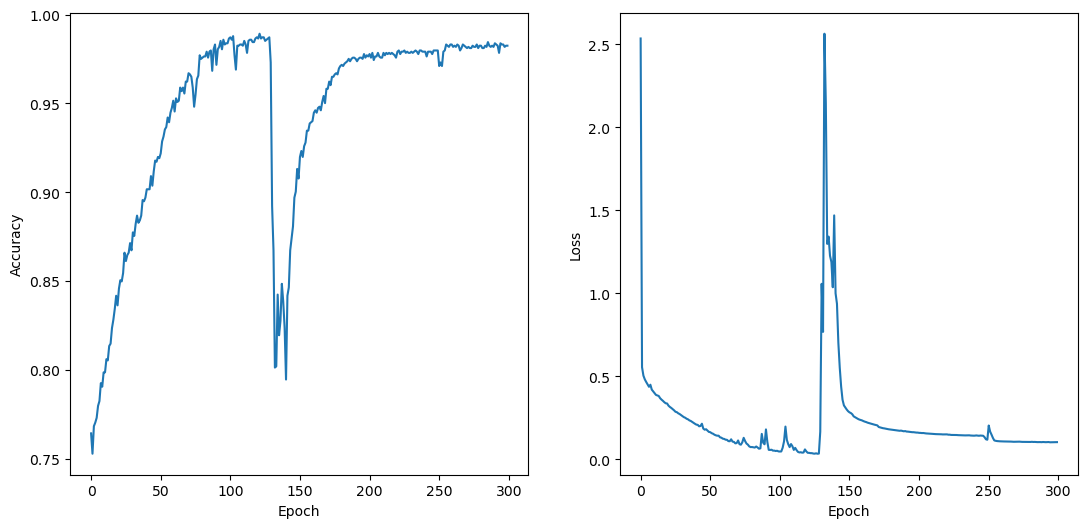

In [19]:
# Se muestran las gráficas de precisiónn y pérdida
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.plot(proceso.history['acc'])
ax1.set(xlabel= 'Epoch', ylabel='Accuracy');
ax2.plot((proceso.history['loss']))
ax2.set(xlabel= 'Epoch', ylabel='Loss');

In [20]:
# Se evalua el modelo
resultado  = modelo.evaluate(Xtest,  Ytest)
print("\nEl test loss obtenido ha sido:", resultado[0])
print("La precisión obtenida ha sido:", resultado[1])

636/636 [==============================] - 0s 189us/sample - loss: 2.9695 - acc: 0.7280

El test loss obtenido ha sido: 2.9695223022556907
La precisión obtenida ha sido: 0.7279874


In [21]:
# Se realizan predicciones
Ypredic= modelo.predict(Xtest)

# Se pasan las predicciones a 0s y 1s
Yprocesada = []
for y in Ypredic:
    if y <= 0.5:
        Yprocesada.append(0)
    else:
        Yprocesada.append(1)

In [22]:
# Se muestra la matriz de confusión
print("La matriz de confusion obtenida es:\n", confusion_matrix(Ytest, Yprocesada))

La matriz de confusion obtenida es:
 [[399  87]
 [ 86  64]]


### Sobremuestreo de los datos

In [23]:
# Se crea el ROS
#ros = RandomOverSampler()
sm = SMOTE()

In [24]:
# Se realiza un sobremuestreo de los datos
Xsm, Ysm = sm.fit_resample(nuevoX, Y)

In [25]:
# Se pasan los datos 2D a 3D para el modelo
Xsm = np.expand_dims(Xsm, axis=-1)
Xsm.shape

(3240, 208, 1)

In [26]:
# Se obtienen los datos para train y para test
Xtrainsm, Xtestsm, Ytrainsm, Ytestsm = train_test_split(Xsm, Ysm, test_size=0.3, random_state=18)

In [27]:
# Se crea y se muestra el modelo
modelo2 = Sequential();
modelo2.add(Conv1D(32, 3, activation='relu', input_shape=(maxLongitud, 1)))
modelo2.add(MaxPooling1D(2))
modelo2.add(Flatten())
modelo2.add(Dense(32, activation='relu'))
modelo2.add(Dense(8, activation='relu'))
modelo2.add(Dense(1, activation='relu'))

modelo2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 206, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 103, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3296)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                105504    
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 105,905
Trainable params: 105,905
Non-trainable params: 0
________________________________________________

In [28]:
# Se compila el modelo
modelo2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
# Se entrena el modelo
proceso2 = modelo2.fit(Xtrainsm, Ytrainsm, epochs=300, batch_size=100)

Epoch 1/300
2268/2268 [==============================] - 1s 265us/sample - loss: 0.8483 - acc: 0.5789
Epoch 2/300
2268/2268 [==============================] - 0s 162us/sample - loss: 0.5763 - acc: 0.7050
Epoch 3/300
2268/2268 [==============================] - 0s 159us/sample - loss: 0.5309 - acc: 0.7372
Epoch 4/300
2268/2268 [==============================] - 0s 163us/sample - loss: 0.4949 - acc: 0.7518
Epoch 5/300
2268/2268 [==============================] - 0s 171us/sample - loss: 0.4749 - acc: 0.7663
Epoch 6/300
2268/2268 [==============================] - 0s 202us/sample - loss: 0.5065 - acc: 0.7804
Epoch 7/300
2268/2268 [==============================] - 0s 196us/sample - loss: 0.4630 - acc: 0.7945
Epoch 8/300
2268/2268 [==============================] - 0s 201us/sample - loss: 0.4575 - acc: 0.8011
Epoch 9/300
2268/2268 [==============================] - 0s 188us/sample - loss: 0.4389 - acc: 0.7976
Epoch 10/300
2268/2268 [==============================] - 0s 187us/sample - loss: 

2268/2268 [==============================] - 0s 167us/sample - loss: 0.1158 - acc: 0.9665
Epoch 81/300
2268/2268 [==============================] - 0s 154us/sample - loss: 0.1171 - acc: 0.9696
Epoch 82/300
2268/2268 [==============================] - 0s 192us/sample - loss: 0.1083 - acc: 0.9705
Epoch 83/300
2268/2268 [==============================] - 0s 187us/sample - loss: 0.1132 - acc: 0.9718
Epoch 84/300
2268/2268 [==============================] - 0s 198us/sample - loss: 0.1124 - acc: 0.9727
Epoch 85/300
2268/2268 [==============================] - 0s 198us/sample - loss: 0.1240 - acc: 0.9705
Epoch 86/300
2268/2268 [==============================] - 0s 198us/sample - loss: 0.1206 - acc: 0.9678
Epoch 87/300
2268/2268 [==============================] - 0s 184us/sample - loss: 0.1058 - acc: 0.9731
Epoch 88/300
2268/2268 [==============================] - 0s 190us/sample - loss: 0.1051 - acc: 0.9687
Epoch 89/300
2268/2268 [==============================] - 0s 187us/sample - loss: 0.10

2268/2268 [==============================] - 0s 194us/sample - loss: 0.7740 - acc: 0.8752
Epoch 160/300
2268/2268 [==============================] - 0s 185us/sample - loss: 0.4771 - acc: 0.9303
Epoch 161/300
2268/2268 [==============================] - 0s 185us/sample - loss: 0.2982 - acc: 0.9559
Epoch 162/300
2268/2268 [==============================] - 0s 183us/sample - loss: 0.2462 - acc: 0.9705
Epoch 163/300
2268/2268 [==============================] - 0s 183us/sample - loss: 0.2221 - acc: 0.9780
Epoch 164/300
2268/2268 [==============================] - 0s 185us/sample - loss: 0.2035 - acc: 0.9793
Epoch 165/300
2268/2268 [==============================] - 0s 186us/sample - loss: 0.1987 - acc: 0.9819
Epoch 166/300
2268/2268 [==============================] - 0s 193us/sample - loss: 0.1966 - acc: 0.9824
Epoch 167/300
2268/2268 [==============================] - 0s 182us/sample - loss: 0.1941 - acc: 0.9819
Epoch 168/300
2268/2268 [==============================] - 0s 188us/sample - l

2268/2268 [==============================] - 0s 195us/sample - loss: 0.1766 - acc: 0.9841
Epoch 238/300
2268/2268 [==============================] - 0s 208us/sample - loss: 0.1769 - acc: 0.9841
Epoch 239/300
2268/2268 [==============================] - 0s 191us/sample - loss: 0.1769 - acc: 0.9841
Epoch 240/300
2268/2268 [==============================] - 0s 194us/sample - loss: 0.1769 - acc: 0.9841
Epoch 241/300
2268/2268 [==============================] - 0s 186us/sample - loss: 0.1767 - acc: 0.9846
Epoch 242/300
2268/2268 [==============================] - 0s 193us/sample - loss: 0.1773 - acc: 0.9832
Epoch 243/300
2268/2268 [==============================] - 0s 200us/sample - loss: 0.1767 - acc: 0.9846
Epoch 244/300
2268/2268 [==============================] - 0s 205us/sample - loss: 0.1761 - acc: 0.9841
Epoch 245/300
2268/2268 [==============================] - 0s 175us/sample - loss: 0.1761 - acc: 0.9846
Epoch 246/300
2268/2268 [==============================] - 0s 182us/sample - l

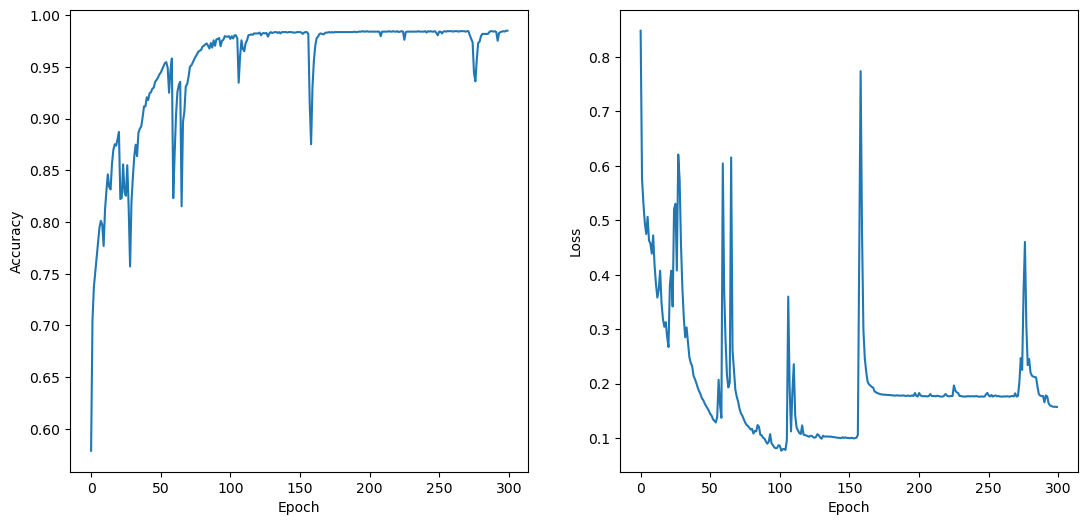

In [30]:
# Se muestran las gráficas de precisiónn y pérdida
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
ax1.plot(proceso2.history['acc'])
ax1.set(xlabel= 'Epoch', ylabel='Accuracy');
ax2.plot((proceso2.history['loss']))
ax2.set(xlabel= 'Epoch', ylabel='Loss');

In [31]:
# Se evalua el modelo
resultado  = modelo2.evaluate(Xtestsm,  Ytestsm)
print("\nEl test loss obtenido ha sido:", resultado[0])
print("La precisión obtenida ha sido:", resultado[1])

972/972 [==============================] - 0s 161us/sample - loss: 2.1257 - acc: 0.7922

El test loss obtenido ha sido: 2.1256732842559187
La precisión obtenida ha sido: 0.7921811


In [32]:
# Se realizan predicciones
Ypredic= modelo.predict(Xtestsm)

# Se pasan las predicciones a 0s y 1s
Yprocesada = []
for y in Ypredic:
    if y <= 0.5:
        Yprocesada.append(0)
    else:
        Yprocesada.append(1)

In [34]:
# Se muestra la matriz de confusión
print("La matriz de confusion obtenida es:\n", confusion_matrix(Ytestsm, Yprocesada))

La matriz de confusion obtenida es:
 [[430  36]
 [198 308]]


### Aplicando Cross Validation

#### Datos originales

In [35]:
# Validación cruzada de 10 modelos
kfold = KFold(10)
# Se concatenan las features y lables destinadas pora train y test en el modelo anterior
features = np.concatenate((Xtrain, Xtest), axis=0)
labels = np.concatenate((Ytrain, Ytest), axis=0)
# Contador del número de modelo que se esta construyendo
kContador = 1
# Listas que contendrán los modelos generados junto con su historial
modelos = []
historial = []

# Se empieza la validación cruzada
for train, test in kfold.split(features, labels):
    # Se muestra el número de modelo y se construye
    print("\nModelo", kContador)
    modelo = Sequential();
    modelo.add(Conv1D(32, 3, activation='relu', input_shape=(maxLongitud, 1)))
    modelo.add(MaxPooling1D(2))
    modelo.add(Flatten())
    modelo.add(Dense(32, activation='relu'))
    modelo.add(Dense(8, activation='relu'))
    modelo.add(Dense(1, activation='relu'))
    
    # Se compila el modelo
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Se entrena el modelo y se guarda el historial de entrenamiento y el modelo obtenido
    proceso = modelo.fit(features[train], labels[train], epochs=300, batch_size=100, verbose=0)
    historial.append(proceso)
    modelos.append(modelo)
    
    # Se evalua el modelo y se muestran los datos
    resultado  = modelo.evaluate(features[test],  labels[test], verbose=0)
    print("\nEl test loss obtenido ha sido:", resultado[0])
    print("La precisión obtenida ha sido:", resultado[1])
    
    # Se incrementa en 1 el contador de modelos
    kContador+=1


Modelo 1

El test loss obtenido ha sido: 2.19427938056442
La precisión obtenida ha sido: 0.754717

Modelo 2

El test loss obtenido ha sido: 3.7834779541447476
La precisión obtenida ha sido: 0.754717

Modelo 3

El test loss obtenido ha sido: 2.6915790090021097
La precisión obtenida ha sido: 0.7264151

Modelo 4

El test loss obtenido ha sido: 2.903541753876884
La precisión obtenida ha sido: 0.7311321

Modelo 5

El test loss obtenido ha sido: 2.333051069727484
La precisión obtenida ha sido: 0.7735849

Modelo 6

El test loss obtenido ha sido: 1.7145048514851984
La precisión obtenida ha sido: 0.7924528

Modelo 7

El test loss obtenido ha sido: 2.580481583217405
La precisión obtenida ha sido: 0.7264151

Modelo 8

El test loss obtenido ha sido: 2.553904524389303
La precisión obtenida ha sido: 0.759434

Modelo 9

El test loss obtenido ha sido: 3.3248250754374378
La precisión obtenida ha sido: 0.7122642

Modelo 10

El test loss obtenido ha sido: 1.8371762464631278
La precisión obtenida ha sido

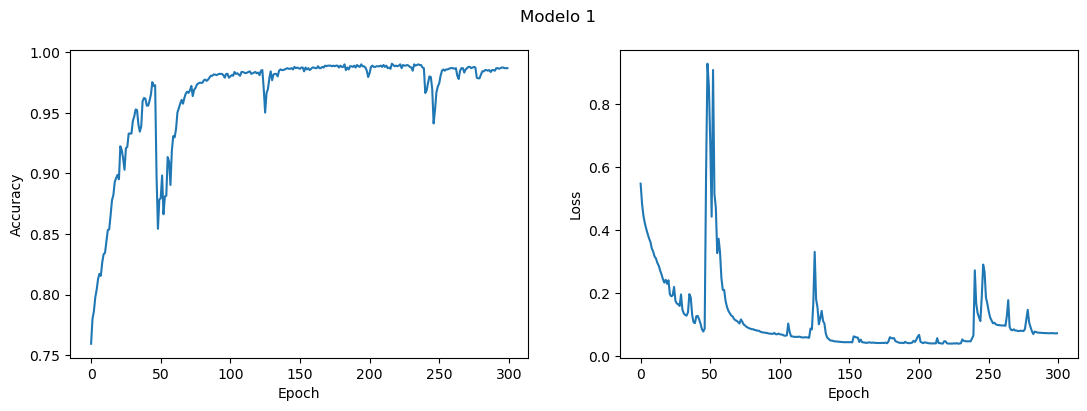

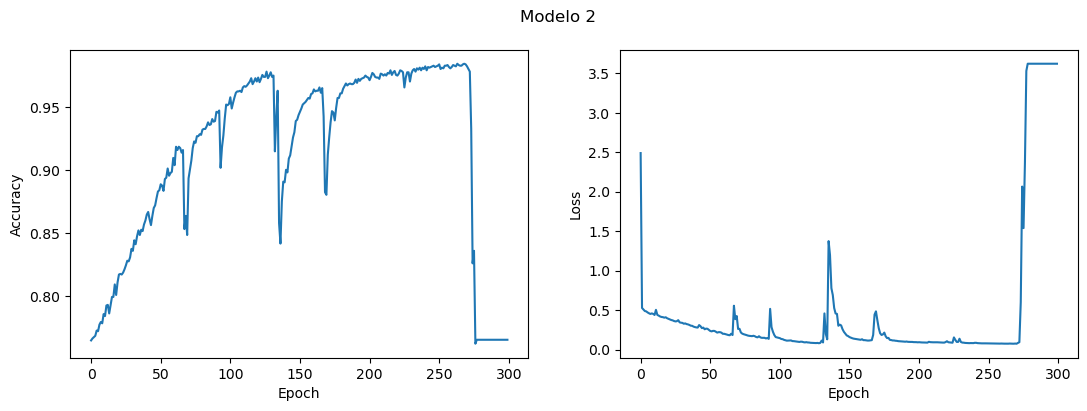

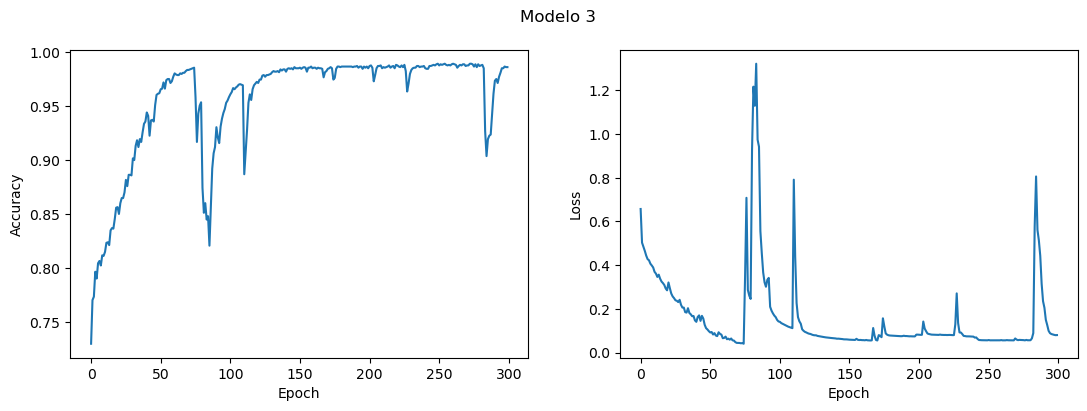

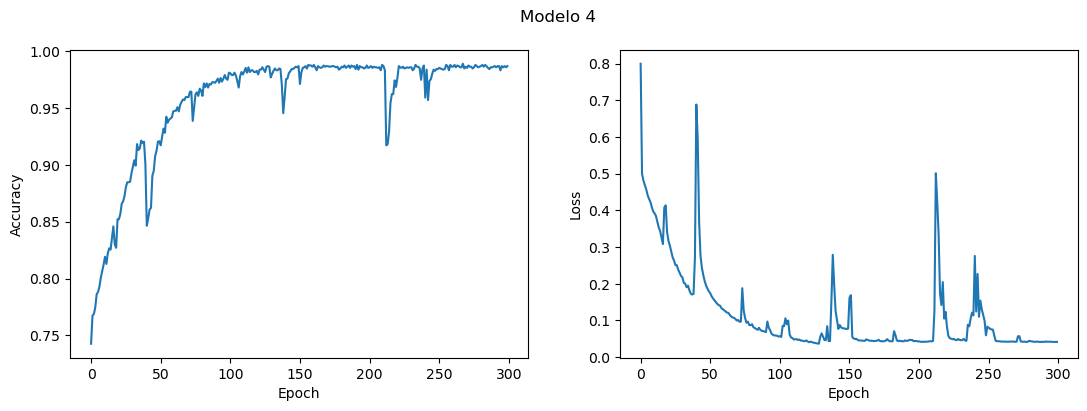

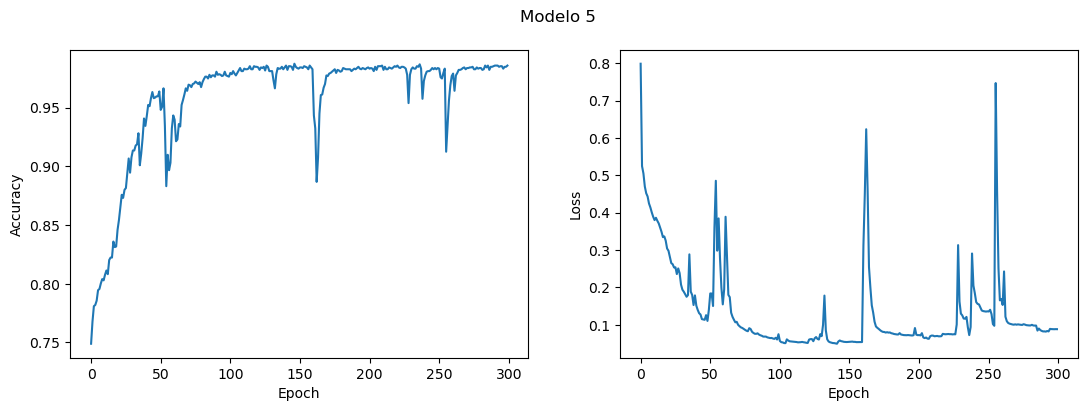

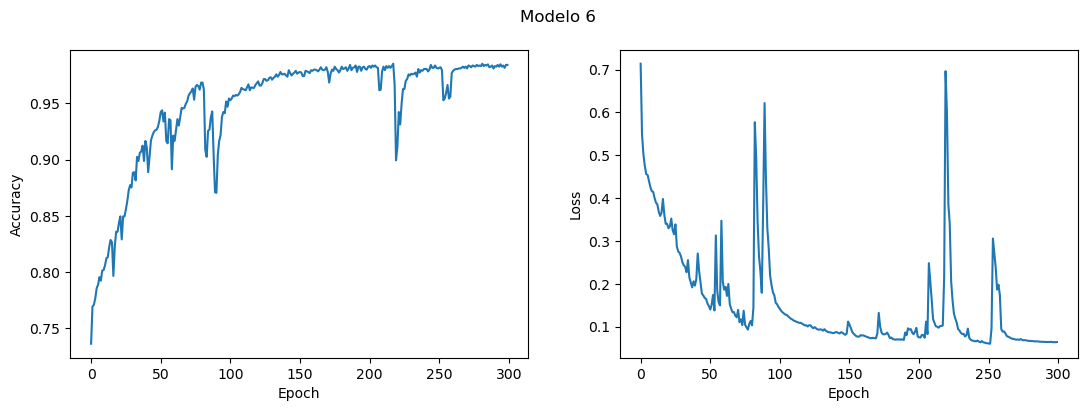

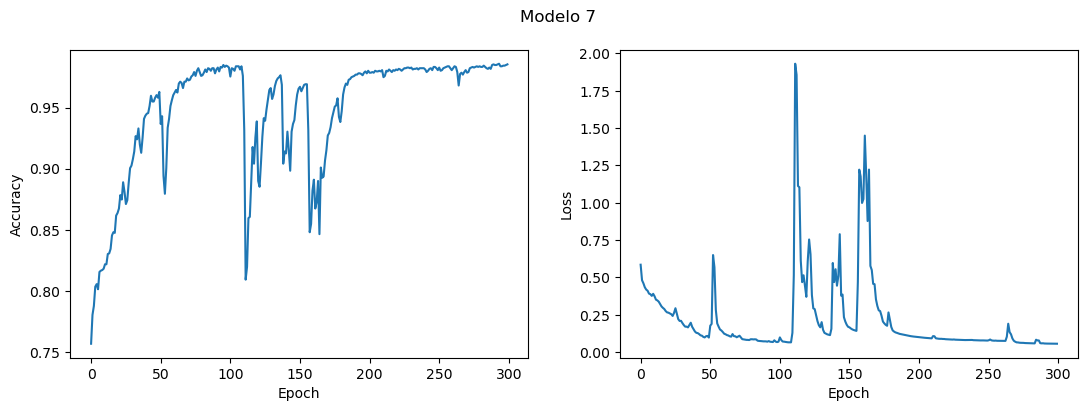

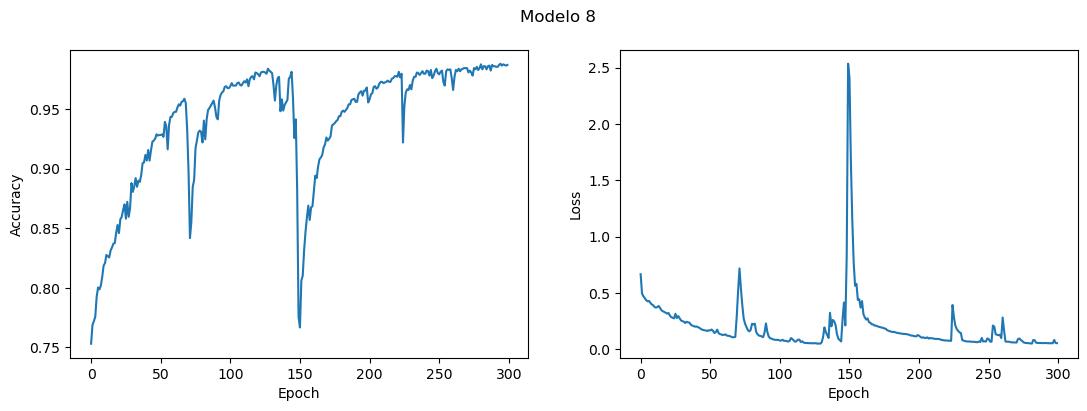

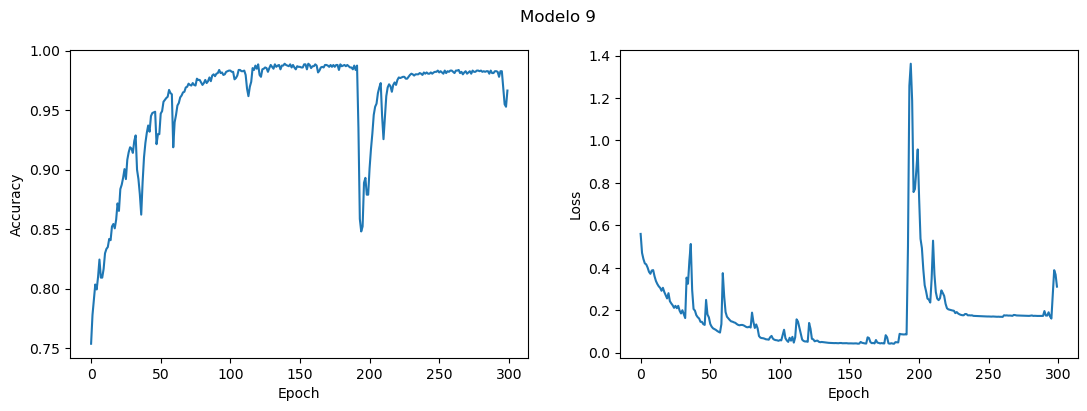

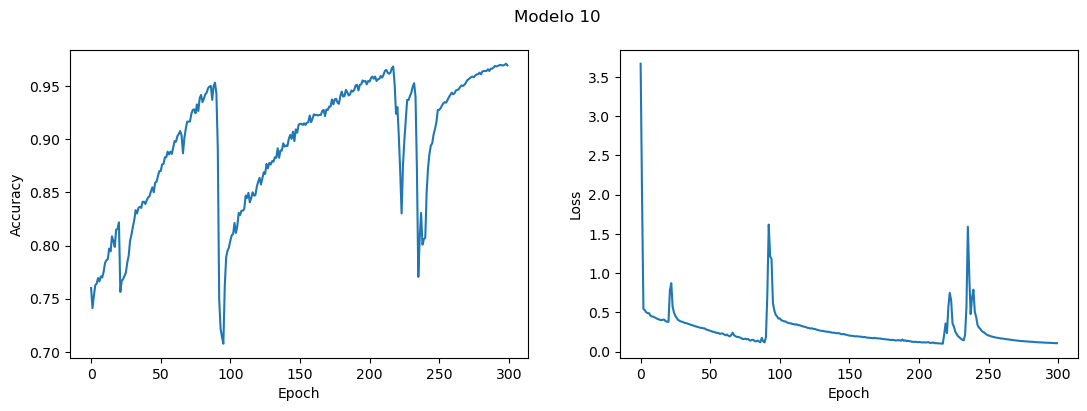

In [36]:
# Se muestran las gráficas de todos los modelos
for i in range(len(historial)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
    fig.suptitle("Modelo " + str(i+1))
    ax1.plot(historial[i].history['acc'])
    ax1.set(xlabel= 'Epoch', ylabel='Accuracy');
    ax2.plot((historial[i].history['loss']))
    ax2.set(xlabel= 'Epoch', ylabel='Loss');
    

#### Datos con sobremuestreo

In [37]:
# Validación cruzada de 10 modelos
kfold = KFold(10)
# Se concatenan las features y lables destinadas pora train y test en el modelo anterior
features = np.concatenate((Xtrainsm, Xtestsm), axis=0)
labels = np.concatenate((Ytrainsm, Ytestsm), axis=0)
# Contador del número de modelo que se esta construyendo
kContador = 1
# Listas que contendrán los modelos generados junto con su historial
modelos2 = []
historial2 = []

for train, test in kfold.split(features, labels):
    # Se muestra el número de modelo y se construye
    print("\nModelo", kContador)
    modelo = Sequential();
    modelo.add(Conv1D(32, 3, activation='relu', input_shape=(maxLongitud, 1)))
    modelo.add(MaxPooling1D(2))
    modelo.add(Flatten())
    modelo.add(Dense(32, activation='relu'))
    modelo.add(Dense(8, activation='relu'))
    modelo.add(Dense(1, activation='relu'))
    
    # Se compila el modelo
    modelo.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])    
    
    # Se entrena el modelo y se guarda el histotial y el modelo
    proceso = modelo.fit(features[train], labels[train], epochs=300, batch_size=100, verbose=0)
    historial2.append(proceso)
    modelos2.append(modelo)
    
    # Se evalua el modelo y se muestra
    resultado  = modelo.evaluate(features[test],  labels[test], verbose=0)
    print("\nEl test loss obtenido ha sido:", resultado[0])
    print("La precisión obtenida ha sido:", resultado[1])
    
    # Se incrementa en 1 el contador de modelos
    kContador+=1


Modelo 1

El test loss obtenido ha sido: 1.4014171464943592
La precisión obtenida ha sido: 0.77469134

Modelo 2

El test loss obtenido ha sido: 1.1765473047156392
La precisión obtenida ha sido: 0.8240741

Modelo 3

El test loss obtenido ha sido: 1.7162816789415147
La precisión obtenida ha sido: 0.80246913

Modelo 4

El test loss obtenido ha sido: 1.7084100539393632
La precisión obtenida ha sido: 0.81790125

Modelo 5

El test loss obtenido ha sido: 1.8511846330430772
La precisión obtenida ha sido: 0.82098764

Modelo 6

El test loss obtenido ha sido: 1.6674023734198675
La precisión obtenida ha sido: 0.83641976

Modelo 7

El test loss obtenido ha sido: 2.032484178189878
La precisión obtenida ha sido: 0.7962963

Modelo 8

El test loss obtenido ha sido: 1.551443194165642
La precisión obtenida ha sido: 0.8240741

Modelo 9

El test loss obtenido ha sido: 1.7537313398019767
La precisión obtenida ha sido: 0.82098764

Modelo 10

El test loss obtenido ha sido: 2.2440929177366655
La precisión obt

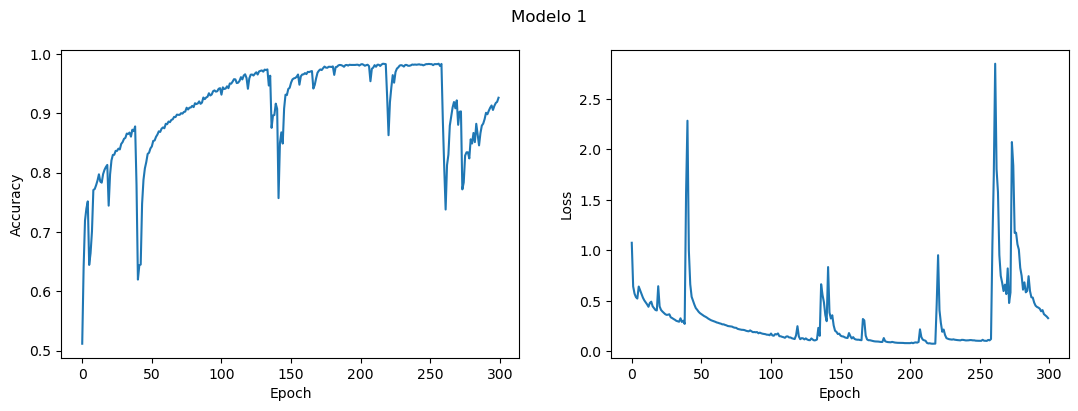

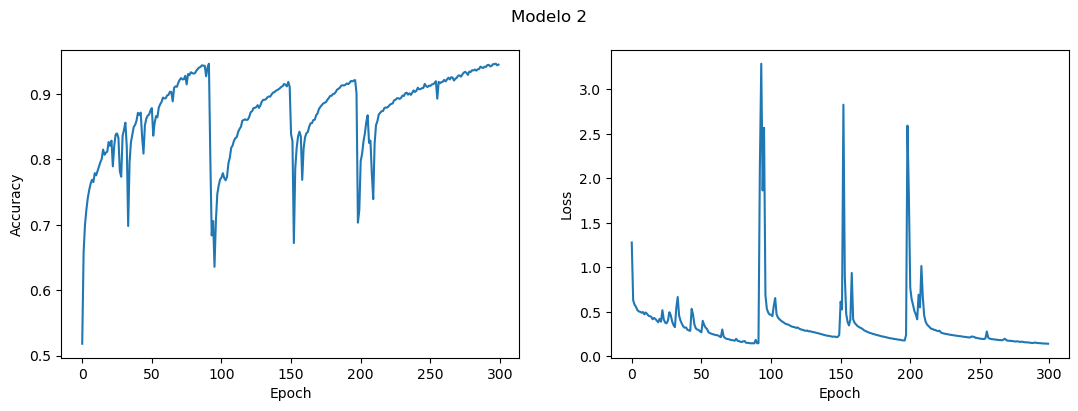

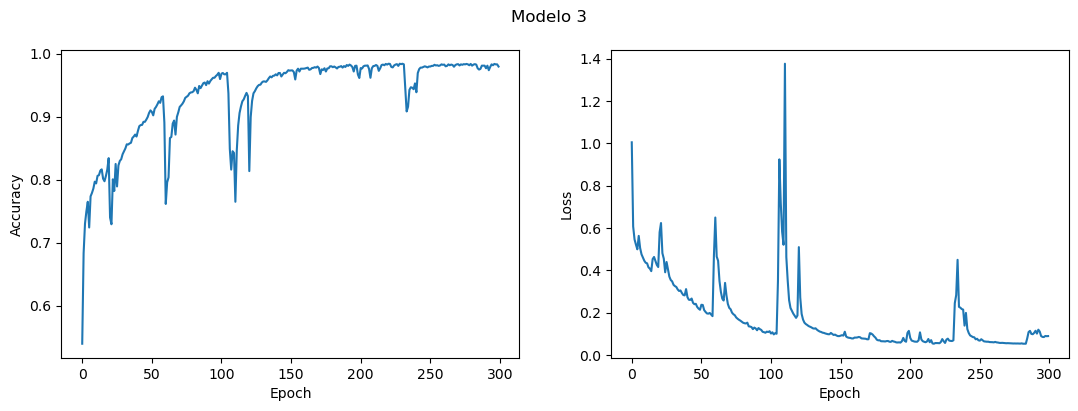

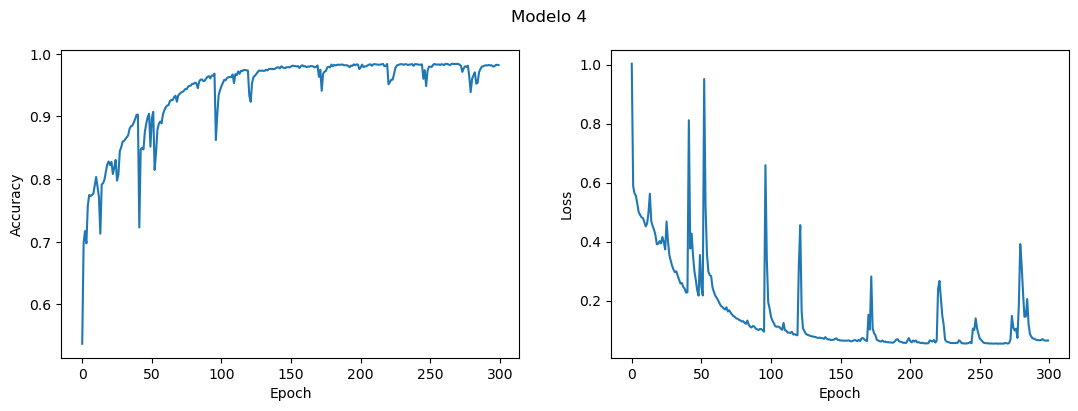

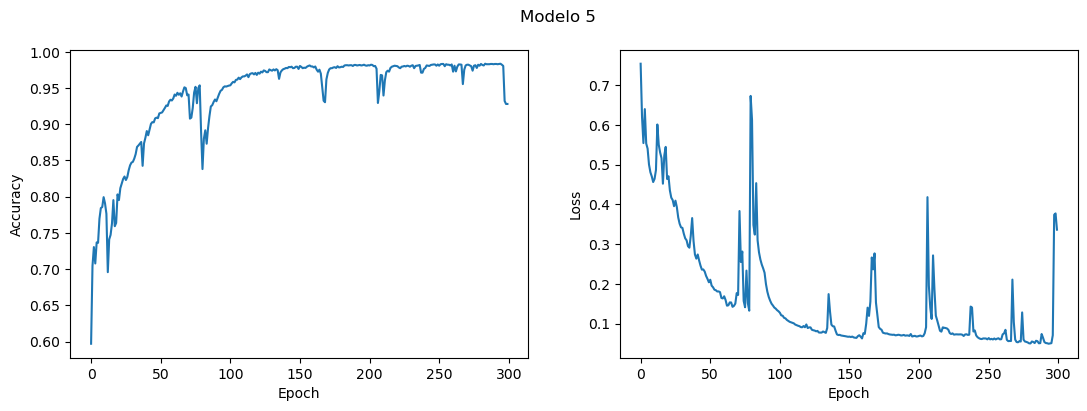

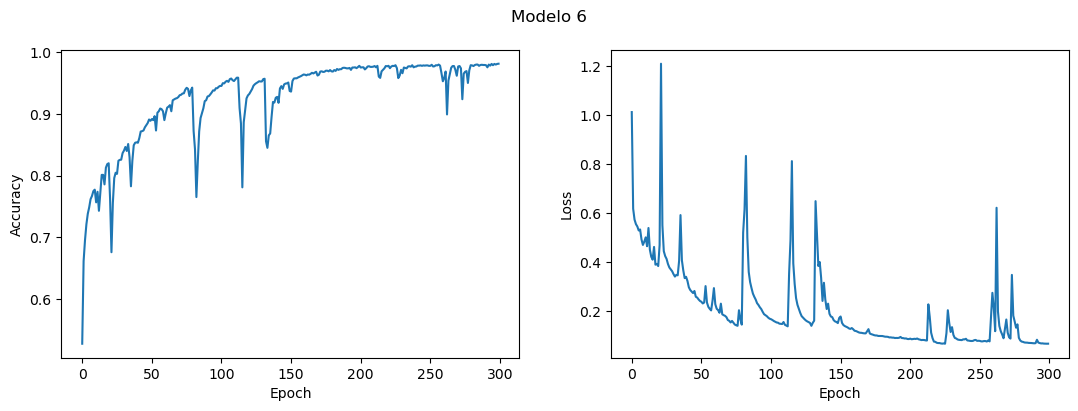

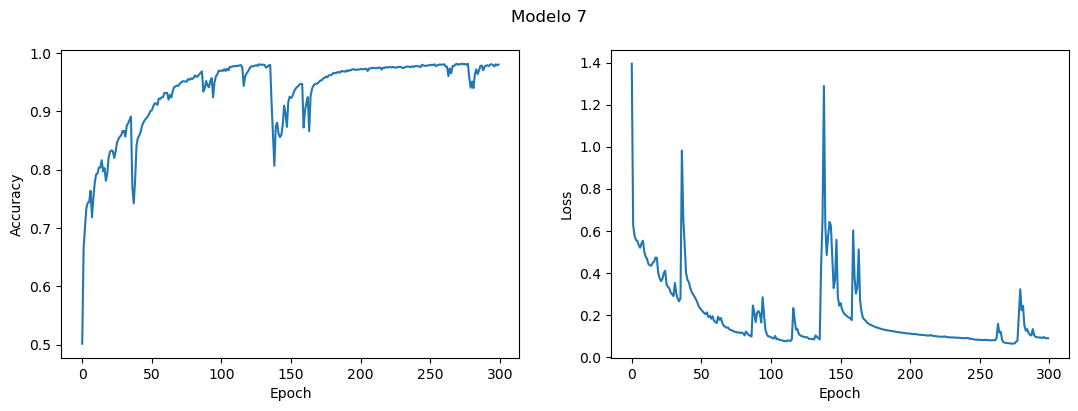

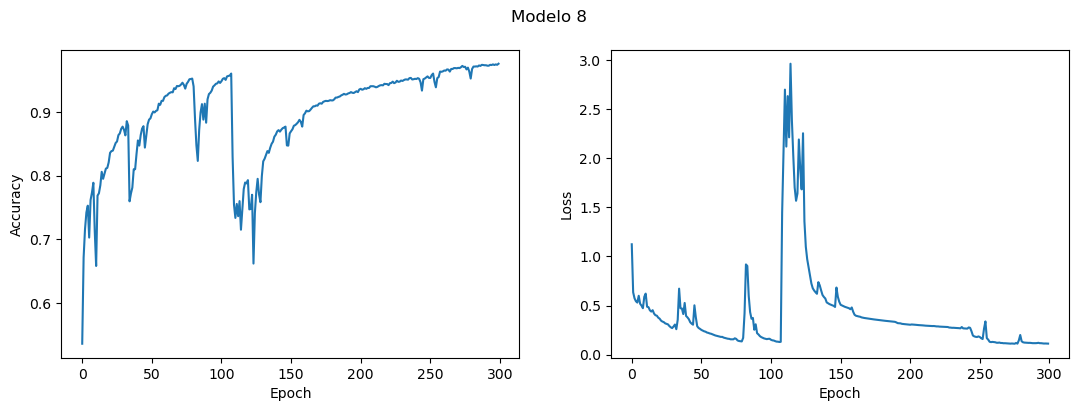

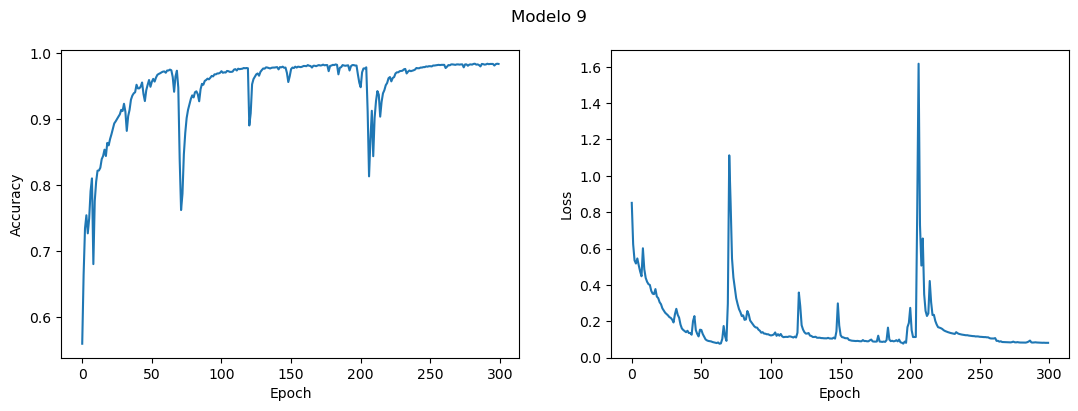

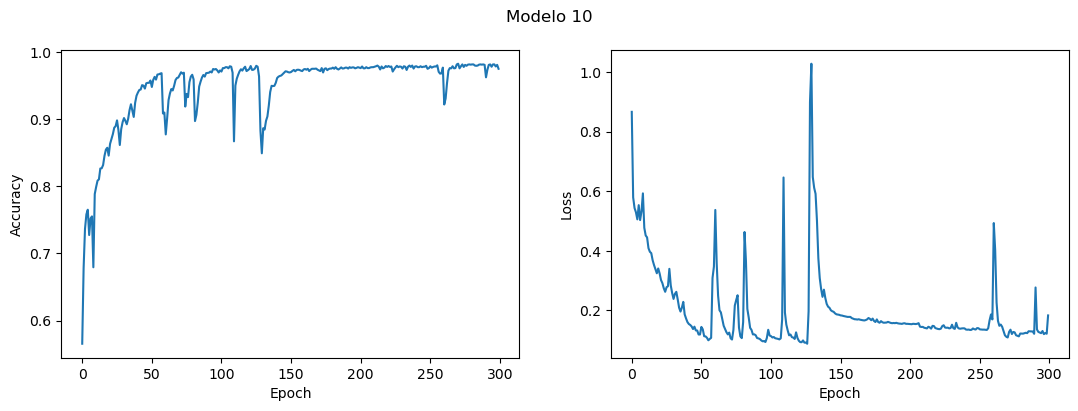

In [38]:
# Se muestran las gráficas de todos los modelos obtenidos
for i in range(len(historial2)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
    fig.suptitle("Modelo " + str(i+1))
    ax1.plot(historial2[i].history['acc'])
    ax1.set(xlabel= 'Epoch', ylabel='Accuracy');
    ax2.plot((historial2[i].history['loss']))
    ax2.set(xlabel= 'Epoch', ylabel='Loss');

### Guardar todos los modelos

In [46]:
# Se crean los directorios donde se van a guardar los modelos
os.makedirs('cnn/original', exist_ok=True)
os.makedirs('cnn/sobremuestreo', exist_ok=True)
os.makedirs('cnn/valcruz/original', exist_ok=True)
os.makedirs('cnn/valcruz/sobremuestreo', exist_ok=True)

In [48]:
# Se guarda el modelo con los datos originales
modelo.save('cnn/original/modelo')
# Se guarda el modelo aplicando sobremuestreo en los datos
modelo2.save('cnn/sobremuestreo/modelo')
# Se guarda el modelo obtenido con validación cruzada con datos originales
for i in range(len(modelos)):
    modelos[i].save('cnn/valcruz/original/modelo' + str(i+1))
# Se guarda el modelo obtenido con validación cruzada aplicando sobremuestreo en los datos    
for i in range(len(modelos2)):
    modelos2[i].save('cnn/valcruz/sobremuestreo/modelo' + str(i+1))